# Prelim Skills Exam - CNN Network Architectures

Submitted By: Labbao, Benedick D.<br>
Performed On: 03/12/2024<br>
Submitted On: 03/14/2024

Submitted To: Engr. Roman M. Richard

---

## Data Preparation

In [1]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
from google.colab import userdata
import keras
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

userdata.get('kaggle_api')

In [ ]:
od.download("https://www.kaggle.com/datasets/nih-chest-xrays/data", force=True)

In [ ]:
# all_xray_df = pd.read_csv('/content/sample/sample_labels.csv')
# all_xray_df.drop("Unnamed: 11", axis=1, inplace=True)
# all_xray_df.head()

In [ ]:
all_xray_df = pd.read_csv('/content/data/Data_Entry_2017.csv')
all_xray_df.drop("Unnamed: 11", axis=1, inplace=True)
all_xray_df.head()

In [ ]:
# all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/content', 'sample', 'sample', 'images', '*.png'))}

all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/content', 'data', 'images*', '*', '*.png'))}
all_image_paths.update({os.path.basename(x): x for x in glob(os.path.join('/content', 'drive', 'MyDrive*', '3RD YR. - 2ND SEM.', 'CPE 313', 'Prelim Skill Exam', 'images*', '*', '*.png'))})

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

In [ ]:
# Missing Images
all_xray_df.dropna(inplace=True)
all_xray_df.shape

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

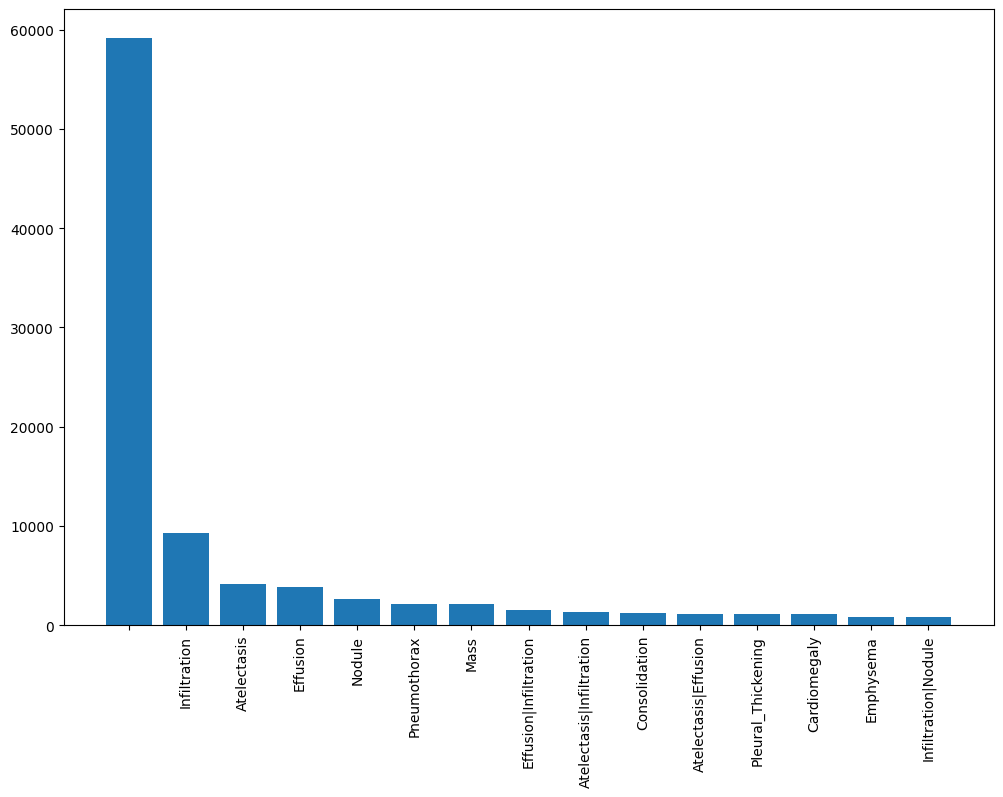

In [28]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

(20000, 26)

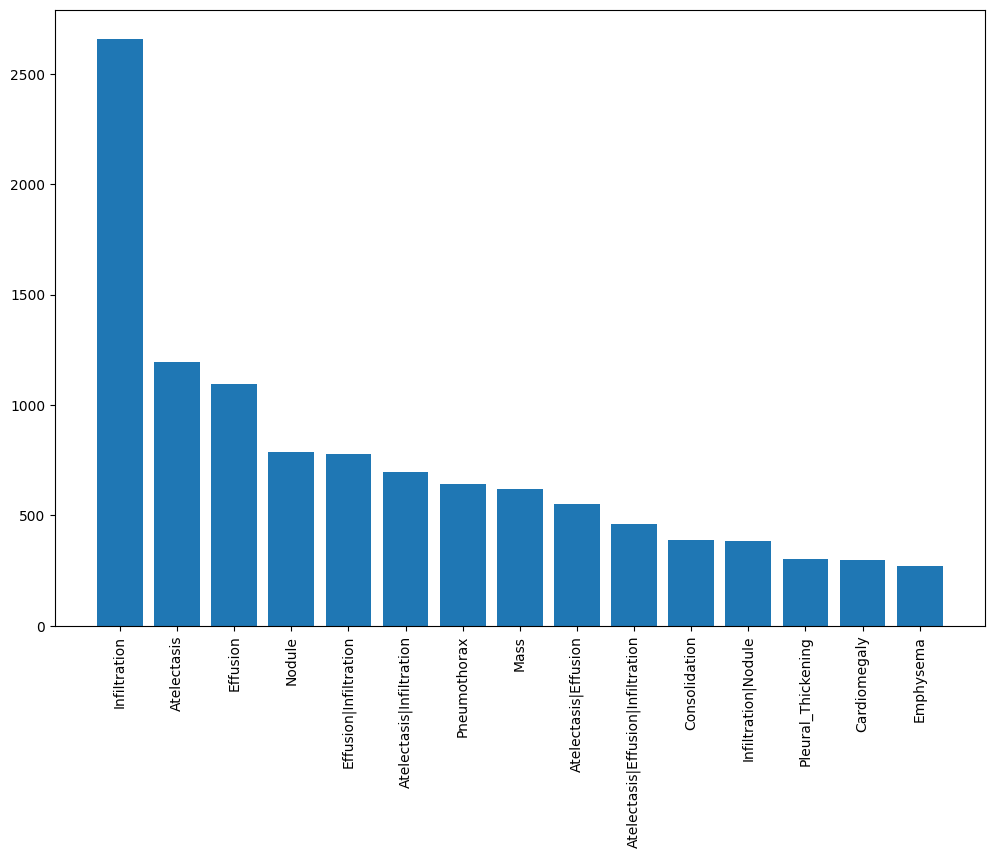

In [29]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 1e-5
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(20000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)
all_xray_df.shape

### Prepare training data

In [30]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
107474,00029033_000.png,Effusion|Pleural_Thickening,0,29033,53,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[Effusion, Pleural_Thickening]"
64253,00015847_004.png,Atelectasis,4,15847,42,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[Atelectasis]
8702,00002300_010.png,Pleural_Thickening,10,2300,81,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,[Pleural_Thickening]
92300,00023065_033.png,Effusion|Pneumothorax,33,23065,50,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[Effusion, Pneumothorax]"
68771,00016972_007.png,Atelectasis|Consolidation|Infiltration,7,16972,43,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[Atelectasis, Consolidation, Infiltration]"


In [31]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.3,
                                   random_state = 10001,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape, 'validation', valid_df.shape)

train (14000, 27) validation (6000, 27)


### Data Generators

In [72]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

In [73]:
train_image_gen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

train_gen = train_image_gen.flow_from_dataframe(train_df,
                            directory=None,
                            x_col = 'path',
                            y_col = 'disease_vec',
                            class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                            color_mode = 'grayscale',
                            batch_size = 32)

Found 14000 validated image filenames belonging to 14 classes.


In [74]:
valid_image_gen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

valid_gen = valid_image_gen.flow_from_dataframe(valid_df,
                            directory=None,
                            x_col = 'path',
                            y_col = 'disease_vec',
                            class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)

test_X, test_Y = next(valid_image_gen.flow_from_dataframe(dataframe=valid_df,
                            directory=None,
                            x_col = 'path',
                            y_col = 'disease_vec',
                            class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                            color_mode = 'grayscale',
                            batch_size = 1024))

Found 6000 validated image filenames belonging to 14 classes.
Found 6000 validated image filenames belonging to 14 classes.


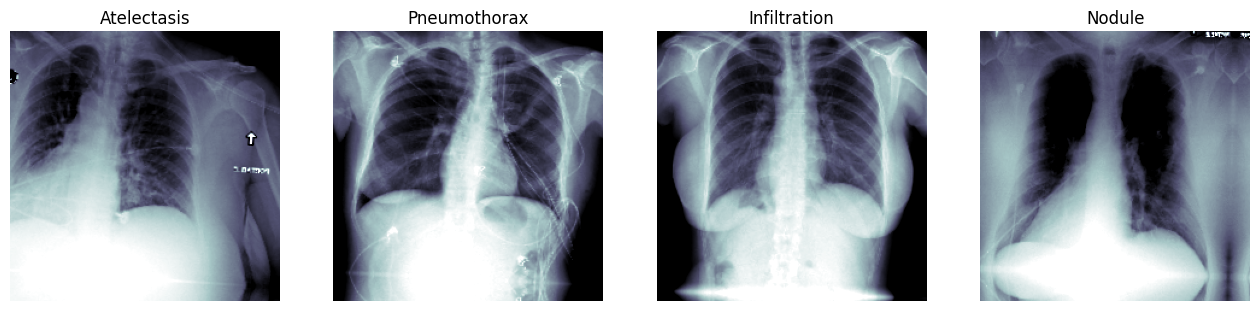

In [75]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(1, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

100%|██████████| 4/4 [00:00<00:00, 33.97it/s]


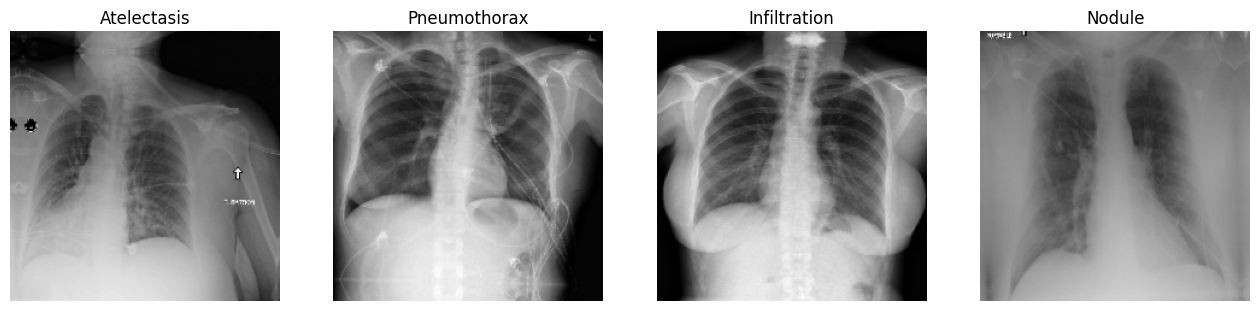

In [76]:
from tqdm import tqdm

def get_label(y):
    """
    Returns the appended label list of the given set.

    y(list) the one hot vector list containing the label encoding.
    """
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(all_labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

x, y = train_gen.__getitem__(0)

#show a set of images along with the labels appended at the top as title.
fig=plt.figure(figsize=(16, 8))
columns = 4
rows = 1
for i in tqdm(range(1, columns*rows +1)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i-1], cmap = 'gray')
    plt.title(get_label(y[i-1]))
    plt.axis(False)
    fig.add_subplot

## Model from scratch

### Model Creation

In [77]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
model_1 = Sequential()

model_1.add(Conv2D(32, (1, 1), strides = (1,1), padding='same',
                 input_shape=t_x.shape[1:]))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides = (2,2)))
model_1.add(Activation('relu'))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(28, (5, 5), strides = (1,1)))
model_1.add(Activation('relu'))

model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

## Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(14, (20, 20), strides = (1,1)))
model_1.add(Activation('relu'))

model_1.add(MaxPooling2D(pool_size=(1, 1)))
model_1.add(Dropout(0.25))

model_1.add(Flatten())
model_1.add(Dense(1024))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(len(all_labels)))
model_1.add(Activation('sigmoid'))

model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 224, 224, 32)      64        
                                                                 
 activation_61 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 conv2d_46 (Conv2D)          (None, 110, 110, 32)      25632     
                                                                 
 activation_62 (Activation)  (None, 110, 110, 32)      0         
                                                                 
 conv2d_47 (Conv2D)          (None, 106, 106, 28)      22428     
                                                                 
 activation_63 (Activation)  (None, 106, 106, 28)      0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 53, 53, 28)      

### Model Training and Validation

In [80]:
def plot_accuracy(valid, train, epochs):
    plt.plot(range(epochs), train, label="Training Accuracy")
    plt.plot(range(epochs), valid, label="Validation Accuracy")
    plt.title("Training vs. Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Percent")
    plt.legend()

def plot_loss(valid, train, epochs):
    plt.plot(range(epochs), train, label="Training Loss")
    plt.plot(range(epochs), valid, label="Validation Loss")
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Percent")
    plt.legend()

def build_lrfn(lr_start=0.000002, lr_max=0.00010,
               lr_min=0, lr_rampup_epochs=8,
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn


lrfn = build_lrfn()
lr_schedule = keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [84]:
opt = keras.optimizers.Adam()

model_1.compile(optimizer=opt, loss='binary_crossentropy',
              metrics=[keras.metrics.binary_accuracy])

In [86]:
epochs = 10

history = model_1.fit(train_gen,
              epochs=epochs,
              steps_per_epoch=50,
              validation_data=valid_gen,
              callbacks=[lr_schedule])


Epoch 1: LearningRateScheduler setting learning rate to 2e-06.
Epoch 1/10
50/50 [==============================] - 839s 17s/step - loss: 0.6083 - binary_accuracy: 0.7710 - val_loss: 0.5161 - val_binary_accuracy: 0.8674 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.425e-05.
Epoch 2/10
50/50 [==============================] - 819s 17s/step - loss: 0.3770 - binary_accuracy: 0.8582 - val_loss: 0.3406 - val_binary_accuracy: 0.8679 - lr: 1.4250e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6500000000000004e-05.
Epoch 3/10
50/50 [==============================] - 767s 15s/step - loss: 0.3555 - binary_accuracy: 0.8594 - val_loss: 0.3403 - val_binary_accuracy: 0.8671 - lr: 2.6500e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.875000000000001e-05.
Epoch 4/10
50/50 [==============================] - 749s 15s/step - loss: 0.3500 - binary_accuracy: 0.8639 - val_loss: 0.3410 - val_binary_accuracy: 0.8675 - lr: 3.8750e-05

Epoch 5: Learn

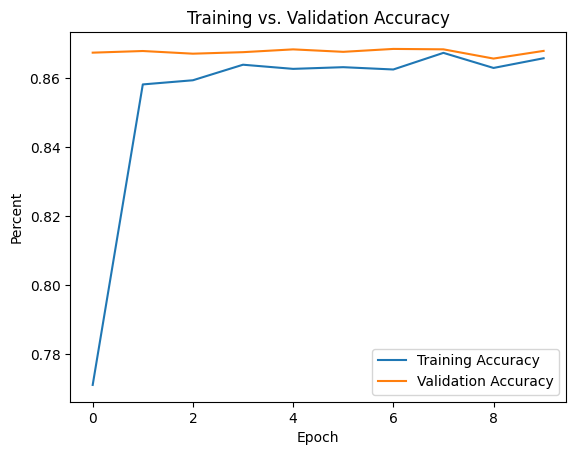

In [91]:
plot_accuracy(history.history["val_binary_accuracy"], history.history["binary_accuracy"], epochs)

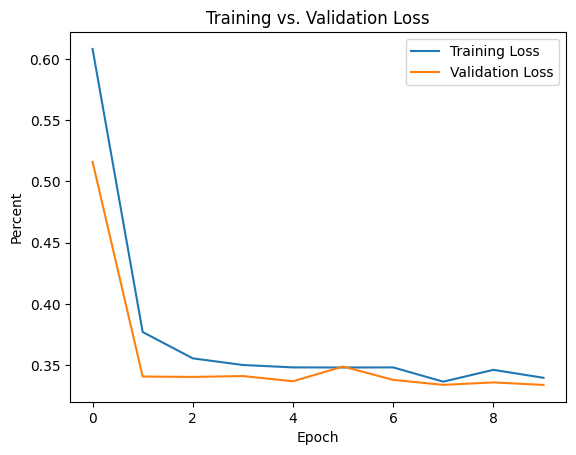

In [92]:
plot_loss(history.history["val_loss"], history.history["loss"], epochs)

In [57]:
model_1.save('/content/drive/MyDrive/3RD YR. - 2ND SEM./CPE 313/Prelim Skill Exam/From_Scratch.keras')
model_1.save_weights('/content/drive/MyDrive/3RD YR. - 2ND SEM./CPE 313/Prelim Skill Exam/From_Scratch.h5')
pd.DataFrame.from_dict(history.history).to_csv('/content/drive/MyDrive/3RD YR. - 2ND SEM./CPE 313/Prelim Skill Exam/From_Scratch.csv', index = False)

## Using pre-trained model

In [95]:
from keras.applications.efficientnet import EfficientNetB7
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential

base_model = EfficientNetB7(
    weights=None,
    input_shape = t_x.shape[1:],
    include_top=False)

multilabel_model = Sequential()
multilabel_model.add(base_model)
multilabel_model.add(GlobalAveragePooling2D())
multilabel_model.add(Dropout(0.5))
multilabel_model.add(Dense(512))
multilabel_model.add(Dropout(0.5))
multilabel_model.add(Dense(len(all_labels), activation = 'sigmoid'))

multilabel_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['accuracy'])

In [96]:
multilabel_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64096531  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_29 (Dropout)        (None, 2560)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1311232   
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 14)              

In [ ]:
multilabel_model.fit(train_gen,
    steps_per_epoch=50,
    validation_data = valid_gen,
    epochs = 1)

### Model Evaluation

In [93]:
from sklearn.metrics import roc_curve, auc

def evaluate(model):
    y_pred = model.predict(test_X)

    for c_label, p_count, t_count in zip(all_labels, 100*np.mean(y_pred,0), 100*np.mean(test_Y,0)):
        print('%s: Actual: %2.2f%%, Predicted: %2.2f%%' % (c_label, t_count, p_count))

    fig, c_ax = plt.subplots(1, 1, figsize=(8,8))
    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC: %0.2f%%)' % (c_label, auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

32/32 [==============================] - 47s 1s/step
Atelectasis: Actual: 28.12%, Predicted: 26.83%
Cardiomegaly: Actual: 7.03%, Predicted: 7.67%
Consolidation: Actual: 11.33%, Predicted: 11.17%
Edema: Actual: 5.76%, Predicted: 7.35%
Effusion: Actual: 32.71%, Predicted: 31.75%
Emphysema: Actual: 5.86%, Predicted: 8.94%
Fibrosis: Actual: 2.93%, Predicted: 6.42%
Hernia: Actual: 0.39%, Predicted: 1.78%
Infiltration: Actual: 42.68%, Predicted: 40.29%
Mass: Actual: 12.79%, Predicted: 16.56%
Nodule: Actual: 13.67%, Predicted: 14.95%
Pleural_Thickening: Actual: 7.13%, Predicted: 10.79%
Pneumonia: Actual: 3.03%, Predicted: 6.06%
Pneumothorax: Actual: 13.48%, Predicted: 16.75%


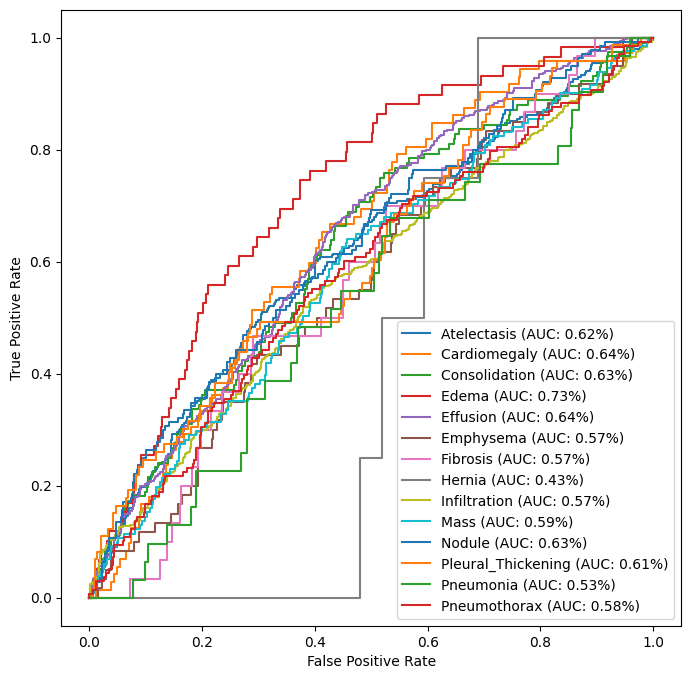

In [94]:
evaluate(model_1)